In [ ]:
!git clone -b autumn_2023 https://github.com/AlekseySpasenov/dl-course.git
%cd /content/dl-course/lecture6
!gdown "1xMDTrHIK_gw3vLsmLZc8N2vCXNGouWQS&confirm=t"
!unzip seminar_objdet_retina_oi5_ball.zip -d seminar_objdet_retina_oi5_ball

Cloning into 'dl-course'...
remote: Enumerating objects: 494, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 494 (delta 34), reused 56 (delta 15), pack-reused 394
Receiving objects: 100% (494/494), 197.80 MiB | 20.67 MiB/s, done.
Resolving deltas: 100% (119/119), done.
Updating files: 100% (116/116), done.
/content/dl-course/lecture6
Downloading...
From: https://drive.google.com/uc?id=1xMDTrHIK_gw3vLsmLZc8N2vCXNGouWQS&confirm=t
To: /content/dl-course/lecture6/seminar_objdet_retina_oi5_ball.zip
100% 1.07G/1.07G [00:11<00:00, 93.8MB/s]
Archive:  seminar_objdet_retina_oi5_ball.zip
  inflating: seminar_objdet_retina_oi5_ball/coco_id_to_name.json  
  inflating: seminar_objdet_retina_oi5_ball/FIXED_coco_resnet_50_map_0_335_state_dict.pt  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0000.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0001.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0003.j

In [ ]:
!ls

dataset.py		requirements.txt		    visualization.py
images			retinanet			    workshop_completed.ipynb
lecture6.detection.pdf	seminar_objdet_retina_oi5_ball	    workshop.ipynb
README.md		seminar_objdet_retina_oi5_ball.zip


In [ ]:
!pip install -r requirements.txt

In [ ]:
import os
import sys
import cv2
import json
import matplotlib.pyplot as plt

import numpy as np
import torch
from torchvision.transforms.functional import to_tensor, normalize

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", device)

from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
#model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT).to(device)
model = fasterrcnn_resnet50_fpn(pretrained=True, progress=True,
                            num_classes=91, pretrained_backbone=True)


categories = FasterRCNN_ResNet50_FPN_Weights.DEFAULT.meta["categories"]

import tqdm

from torchvision import transforms
from torch.utils.data import DataLoader
import torch.utils.data
from PIL import Image


class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict_file, add_path=None, transform=None, target_transform = None):
        self.transform = transform
        self.target_transform = target_transform

        with open(data_dict_file, 'r') as f:
            self.data_dict = json.load(f)
        if add_path:
            self.data_dict = {add_path + i:j for i,j in self.data_dict.items()}

        self.imgs = list(self.data_dict.keys())

    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.imgs[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
        h, w = image.shape[:2]

        num_objs = len(self.data_dict[img_path])
        boxes = []
        for i in range(num_objs):
            bbox = self.data_dict[img_path][i]
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(boxes)
        labels = torch.ones(len(boxes), dtype = torch.int64)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
        return image, {"boxes" : boxes.to(device), "labels" : labels.to(device)}

    def __len__(self):
        return len(self.imgs)

    def num_classes(self):
        return 2


class GaussianNoise(object):
    def __init__(self, mean=0, std=0.001):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean


from torchvision.transforms.v2.functional import permute_channels
from torchvision.transforms import Lambda
from torch.nn.functional import pad

max_size = 2*1024 # максимальный размер изображения

default_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize(max_size),
])
augmented_transform = transforms.Compose([
    default_transform,
    GaussianNoise()
])

def collate_fn(batch):
    max_h = max([img.shape[1] for img,target in batch])
    max_w = max([img.shape[2] for img,target in batch])

    new_batch = []
    for img,target in batch:
        h, w = img.shape[1], img.shape[2]
        pad_h = max_h - h
        pad_w = max_w - w
        padded_img = pad(img, (0, pad_w, 0, pad_h), mode='constant', value=0)
        new_batch.append((padded_img, target))

    return new_batch


train_dataset = DetectionDataset(data_dict_file="seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
                                 add_path = 'seminar_objdet_retina_oi5_ball/',
                                transform = augmented_transform)
train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle = True, batch_size = 4, drop_last = True)


val_dataset = DetectionDataset(data_dict_file="seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
                                 add_path = 'seminar_objdet_retina_oi5_ball/',
                                transform = default_transform)
val_loader = DataLoader(val_dataset, collate_fn=collate_fn, shuffle = False, batch_size = 4, drop_last = False)

from mean_average_precision import MetricBuilder
import gc


def val_step(model, val_loader):
    model.eval()
    metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=False, num_classes=1)
    for iter_num, data in tqdm.tqdm(enumerate(val_loader), total=len(val_loader)):
      for img, gt in data:
        with torch.no_grad():
          bboxes, nms_classes, nms_scores = model(img.unsqueeze(0).to(device))[0].values()
        preds = torch.cat([bboxes, nms_classes.unsqueeze(0).T, nms_scores.unsqueeze(0).T], dim = 1).cpu().detach().numpy()
        zeros = torch.zeros((gt['boxes'].shape[0], 1)).to(device)
        gt = torch.cat([gt['boxes'], gt['labels'].unsqueeze(1), zeros, zeros], 1).cpu().detach().numpy()
        metric_fn.add(preds, gt)

        del img, gt, preds, zeros, nms_scores, nms_classes, bboxes
      gc.collect()
      torch.cuda.empty_cache()
    print(f"validation mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")


loss_history = []

def train(model,train_loader, optimizer):
    model.train()
    epoch_loss = []
    for iter_num, data in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):

        imgs = [img.to(device).float() for img,target in data]
        targets = [target for img,target in data]
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_history.append(loss_value)
        if bool(loss_value == 0):
            continue
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        print(f"{iter_num}/{len(train_loader)}, {loss_value=}")
        epoch_loss.append(float(loss_value))

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 2 # 1 класс для мячей и 1 класс для фона
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(f"1024 = {model.roi_heads.box_predictor.cls_score.in_features}")
print(f"2 = {model.roi_heads.box_predictor.cls_score.out_features}")
print(f"8 = {model.roi_heads.box_predictor.bbox_pred.out_features}")

Device is: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weigh

1024 = 1024
2 = 2
8 = 8


In [ ]:
for param in model.parameters():
    param.requires_grad = True
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=3e-3)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
epochs = 1
for epoch_num in range(epochs):
    train(model, train_loader, optimizer)



In [ ]:
epochs = 4
for epoch_num in range(epochs):
    train(model, train_loader, optimizer)
    print("ended")
    if epoch_num % 1 == 0 or epoch_num + 1 == epochs:
        torch.save(model.state_dict(), f"dev_balls_fasterrcnn_{epoch_num}.pt")

Обучение происходило на кластере моей кафедры

In [ ]:
with open("dev_balls_fasterrcnn_3.pt", "rb") as fp:
    state_dict = torch.load(fp, map_location="cpu")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
iterator = iter(train_dataset)
example = next(iterator)
#example = next(iterator)
exp_img, exp_targets = next(iterator)

model.eval()
predictions = model([exp_img.to(device)])
print(predictions[0])

{'boxes': tensor([[ 461.2517,  508.7278,  604.0262,  651.8900],
        [ 454.7722,  469.2038,  716.6693,  744.3928],
        [ 392.6997,  204.0420,  592.5644,  347.6612],
        [ 132.9883,  182.5359,  283.6550,  313.1335],
        [ 176.4144,   30.7185,  452.5925,  328.0267],
        [ 283.2618,  463.5923,  733.4565,  682.3261],
        [   0.0000,  230.5605,  742.9133,  763.6130],
        [ 574.0947,  445.6393,  720.5429,  731.6562],
        [ 265.7688,  570.4886,  339.5902,  617.0958],
        [ 758.2407,  752.9951,  803.7078,  809.5770],
        [   0.0000,    8.9067,  598.9824,  524.4038],
        [ 480.7976,  211.1416,  570.9178,  328.1481],
        [ 334.4004,   68.3298,  449.7130,  207.0027],
        [ 695.5805,  460.2129,  843.8115,  601.5869],
        [  22.8841,  123.3087,  311.6199,  343.6533],
        [ 230.8489,  181.9081,  276.2021,  199.4852],
        [   0.0000,  410.8787,  824.9816, 1000.7722],
        [ 278.9910,   28.7176,  382.2861,  147.3972],
        [  20.2334

In [ ]:
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
import os
import cv2

font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')

<ipython-input-13-d83cfed44743>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for x, output in zip([torch.tensor(255*exp_img,dtype=torch.uint8)], predictions)


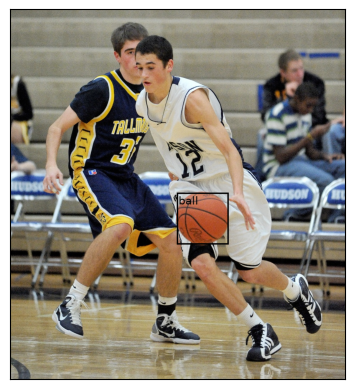

In [ ]:
from torchvision.utils import draw_bounding_boxes
score_threshold = .82
img_with_boxes = [
    draw_bounding_boxes(x,
                        boxes=output['boxes'][output['scores'] > score_threshold],
                        labels= ["ball" for i in output['labels'][output['scores'] > score_threshold]],
                        width=4, font=font_path, font_size = 30)
    for x, output in zip([torch.tensor(255*exp_img,dtype=torch.uint8)], predictions)
]
show(img_with_boxes)